In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from model.data_process import load_dataset, get_train_test_val_split, process_dataset

## Read

In [5]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
!ls

--2023-05-10 15:00:19--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Распознаётся files.grouplens.org (files.grouplens.org)… 128.101.65.152
Подключение к files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 978202 (955K) [application/zip]
Сохранение в: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955,28K   496KB/s    за 1,9s    

2023-05-10 15:00:22 (496 KB/s) - ‘ml-latest-small.zip’ сохранён [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
ExploreDataset.ipynb  ml-latest-small  ml-latest-small.zip  model


In [8]:
df = pd.read_csv("./ml-latest-small/ratings.csv")
#df.userId.unique()
df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


## Evaluation

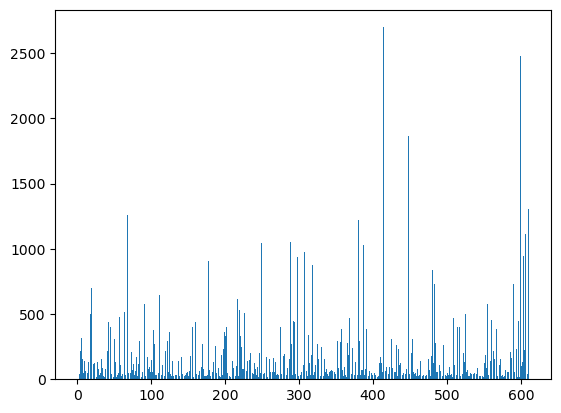

In [3]:
number_of_records_per_user = []
for u in df.userId.unique():
    number_of_records_per_user.append((df.userId == u).sum())
plt.bar(x = df.userId.unique(), height=number_of_records_per_user)
plt.show()

In [4]:
number_of_records_per_user = pd.DataFrame(number_of_records_per_user)
number_of_records_per_user.describe()

,0
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


## Train/val split

In [4]:
train,test,val = get_train_test_val_split(df)

In [5]:
train = process_dataset(train)
val = process_dataset(val)
test = process_dataset(test)

In [6]:
train

,user,item,rating
73,1,1210,5.0
43,1,804,4.0
120,1,2018,5.0
171,1,2628,4.0
183,1,2826,4.0
...,...,...,...
100610,610,101112,3.0
100022,610,7369,2.5
100603,610,100163,3.0
99808,610,4153,3.0


## Model ALS

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("recommendation") \
    .getOrCreate()

In [ ]:
spark_train = spark.createDataFrame(train)

In [ ]:
spark.stop()

In [ ]:
from pyspark.ml.recommendation import ALS

als = ALS()#.setMaxIter(10).setRank(10).setRegParam(1)

In [ ]:
model = als.fit(spark_train)

In [ ]:
u = pd.DataFrame(model.userFactors.collect())
item = pd.DataFrame(model.itemFactors.collect())

In [ ]:
spark_test = spark.createDataFrame(test)
res = pd.DataFrame(model.transform(spark_val).collect(),columns = ["uId","mId","r","r1"])
res

In [61]:
res = res.fillna(0)

### Embeddings

In [ ]:
u = pd.DataFrame(model.userFactors.collect())
item = pd.DataFrame(model.itemFactors.collect())

### Evaluation

In [63]:
from sklearn.metrics import precision_score

RMSE

In [64]:
((res['r']-res['r1'])**2).sum()/len(res)

1.9264351246960887

In [72]:
res['r'] = res['r'].astype('int32')
res['r1'] = res['r1'].astype('int32')

Precision:

In [75]:
precision_score(res['r'],res['r1'],average = 'micro')

0.3112624360088863

## Model draft

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

class IdProcess():
    def __init__(self,pca_size):
        self.enc = OneHotEncoder(handle_unknown='ignore')
        self.pca = PCA(pca_size)
    
    def fit(self,data):
        self.enc = self.enc.fit(data)
        data = self.enc.transform(data).toarray()
        if data.shape[1]>1000:
            data = data[:9000]
        self.pca.fit(data)
        
    def transform(self,data):
        data = self.enc.transform(data).toarray()
        data = self.pca.transform(data)
        return data

In [19]:
t_user = np.array(train.user).reshape(-1,1)
test_user = np.array(test.user).reshape(-1,1)
proc = IdProcess(200)

proc.fit(t_user)
#proc.transform(test_user[[1]])

In [15]:
users,movies = df.userId.unique(), df.movieId.unique()

In [25]:
users_transform = proc.transform(np.array(users).reshape(-1,1))

In [ ]:
t_user = np.array(train.item).reshape(-1,1)
test_user = np.array(test.item).reshape(-1,1)
proc = IdProcess(1000)

proc.fit(t_user)
proc.transform(test_user[[1]])

In [26]:
movies_transform = proc.transform(np.array(movies).reshape(-1,1))

In [ ]:
import torch
from torch import nn

In [ ]:
class User_Embeding(nn.Module):
    def __init__(self):
        self.user_embedding = torch.nn.Embedding(n_users, 15)
        self.linear1 = torch.nn.Linear()
        self.linear2 = torch.nn.Linear()
        self.linear3 = torch.nn.Linear()
    
    def forward(self, uID,uData):
        data = self.user_embedding(uData)
        uID = self.linear1(uID)
        data = self.linear2(data)
        data = uID + data
        data = self.linear3(data)
        
        return data
    
class Item_Embeding(nn.Module):
    def __init__(self):
        self.user_embedding = torch.nn.Embedding(n_users, 15)
        self.linear1 = torch.nn.Linear()
        self.linear2 = torch.nn.Linear()
        self.linear3 = torch.nn.Linear()
    
    def forward(self, uID,uData):
        data = self.user_embedding(uData)
        uID = self.linear1(uID)
        data = self.linear2(data)
        data = uID + data
        data = self.linear3(data)
        
        return data

# model_item = Item_Embeding()
# model_user = User_Embeding()

# r = model_user(id = 1)@model_item(id = 100)
# loss = (r - r_true)**2/batch_size